# Project: Clickbait Headline Classification Using NLP and Machine Learning
## Group 3: Yutong He

This notebook walks through the full pipeline for building a clickbait headline classifier using NLP and machine learning techniques. Run the code cells in order to:

- Import and download necessary libraries and files

- Load and preprocess the headline datasets

- Train and evaluate models using both traditional (TF-IDF, BOW) and transformer-based features

- Visualize results and performance metrics

- Run ablation experiments to assess the effect of stopword removal, truncation, and feature extraction choices

- Implement sentence embedding experiments using sentence-transformers

- Compare and interpret model performance

- Launch a Gradio web UI to allow users to input a headline and classify it using the best-performing model (BOW + Logistic Regression)

In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import gzip
import matplotlib.pyplot as plt

!pip install seaborn

import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

!pip install torch sentence-transformers

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sentence_transformers import SentenceTransformer


from ablation_batch_runner import run_all_ablation_experiments
import pickle
from ablation_runner import run_ablation_experiment

!pip install gradio
import gradio as gr


In [2]:
# Step 2: Load Data from Gzip Files
# The dataset consists of two .gz files, each containing 16,000 headlines.
# Clickbait headlines come from BuzzFeed, Upworthy, ViralNova, etc.
# Non-clickbait headlines are from WikiNews, NYT, The Guardian, and The Hindu.
# Source: https://github.com/bhargaviparanjape/clickbait/tree/master/dataset
# Chakraborty, A., Paranjape, B., Kakarla, S., & Ganguly, N. (2016). Stop Clickbait: Detecting and Preventing Clickbaits in Online News Media. 
# In Proceedings of the 2016 IEEE/ACM International Conference on Advances in Social Networks Analysis and Mining (ASONAM) (pp. 9–16). San Francisco, CA, USA. IEEE.

def load_gzip_lines(filepath):
    with gzip.open(filepath, 'rt', encoding='utf-8') as f:
        return [line.strip() for line in f if line.strip()]

clickbait = load_gzip_lines('clickbait_data.gz')
non_clickbait = load_gzip_lines('non_clickbait_data.gz')

# Combine and shuffle
data = pd.DataFrame({
    'headline': clickbait + non_clickbait,
    'label': [1]*len(clickbait) + [0]*len(non_clickbait)
})

data = data.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

In [3]:
# Step 3: Preprocessing and Feature Extraction
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=5000)
X = vectorizer.fit_transform(data['headline'])
y = data['label']

# First split: 80% train, 20% temp (to later split into validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Second split: 10% validation, 10% test from remaining 20%
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [4]:
# Step 4: Train Models and Evaluate
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\nModel: {name}")
    print(classification_report(y_test, preds))


Model: Naive Bayes
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1600
           1       0.96      0.96      0.96      1600

    accuracy                           0.96      3200
   macro avg       0.96      0.96      0.96      3200
weighted avg       0.96      0.96      0.96      3200


Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1600
           1       0.96      0.94      0.95      1600

    accuracy                           0.95      3200
   macro avg       0.95      0.95      0.95      3200
weighted avg       0.95      0.95      0.95      3200



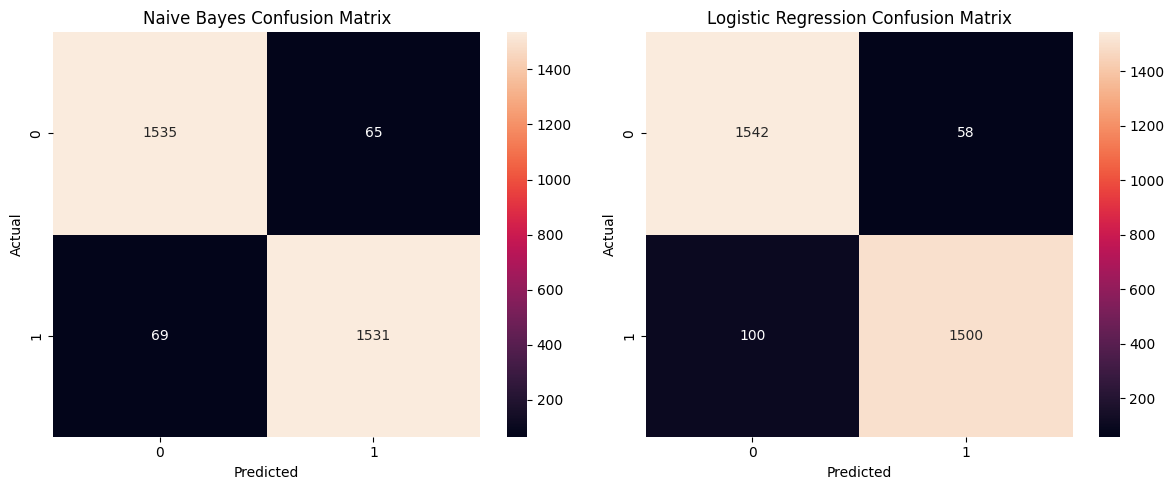

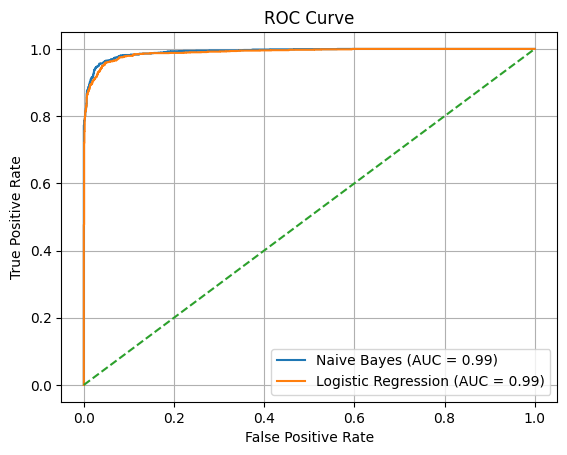

In [5]:
# Step 5: Confusion Matrix and ROC Curve
plt.figure(figsize=(12, 5))
for i, (name, model) in enumerate(models.items()):
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc_score = roc_auc_score(y_test, probs)
    
    plt.subplot(1, 2, i+1)
    sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()

plt.figure()
for name, model in models.items():
    probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, probs):.2f})")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

### Confusion Matrices

| Model                   | True Negatives (TN) | False Positives (FP) | False Negatives (FN) | True Positives (TP) |
| ----------------------- | ------------------- | -------------------- | -------------------- | ------------------- |
| **Naive Bayes**         | 1534                | 66                   | 69                   | 1531                |
| **Logistic Regression** | 1541                | 59                   | 102                  | 1498                |


Naive Bayes has fewer false negatives → better at detecting actual clickbait.

Logistic Regression has fewer false positives → better at avoiding false alarms.

### ROC Curve and AUC
Naive Bayes AUC: 0.99

Logistic Regression AUC: 0.99

Both models show excellent discriminatory ability. Their ROC curves are almost overlapping, suggesting similar performance.

### Observations
- Both classifiers perform exceptionally well on this task.

- Naive Bayes slightly favors sensitivity (recall for clickbait).

- Logistic Regression slightly favors specificity (precision for non-clickbait).

- Either model is a strong baseline, and further improvements could come from tuning features or trying transformer-based embeddings.

### Ablation Experiment

In [6]:
# Step 6: Run Ablation Experiments  
results_df = run_all_ablation_experiments(data)
print(results_df)


  Vectorizer Type Stopwords Truncated  F1 Score  Accuracy  \
0           tfidf   Removed        No    0.9514    0.9514   
1           tfidf   Removed       Yes    0.9187    0.9187   
2           tfidf      Kept        No    0.9700    0.9700   
3           tfidf      Kept       Yes    0.9550    0.9550   
4             bow   Removed        No    0.9500    0.9500   
5             bow   Removed       Yes    0.9175    0.9175   
6             bow      Kept        No    0.9727    0.9727   
7             bow      Kept       Yes    0.9603    0.9603   

                       Trained Model  \
0  LogisticRegression(max_iter=1000)   
1  LogisticRegression(max_iter=1000)   
2  LogisticRegression(max_iter=1000)   
3  LogisticRegression(max_iter=1000)   
4  LogisticRegression(max_iter=1000)   
5  LogisticRegression(max_iter=1000)   
6  LogisticRegression(max_iter=1000)   
7  LogisticRegression(max_iter=1000)   

                                  Trained Vectorizer  
0  TfidfVectorizer(max_features=50

Key Observations:
- The Bag-of-Words (BOW) model with no stopword removal and full headline input achieved the highest performance (F1 Score: 0.9727, Accuracy: 0.9727).

- Contrary to common practice, keeping stopwords improved classification results—likely because certain stopwords (e.g., "what", "how", "why") are strong indicators of clickbait.

- Truncating input to only the first 5 words consistently reduced performance, confirming that clickbait cues often appear later in headlines.

### Sentence Embedding Experiment (Transformer-Based)
To evaluate the effectiveness of semantic features, I conducted an additional experiment using sentence embeddings generated by a pretrained transformer model (all-MiniLM-L6-v2, via sentence-transformers). These embeddings were used as input to a simple logistic regression classifier implemented in PyTorch.

In [7]:
# Step 7: Sentence Embedding + Logistic Regression Experiment

# Load model and encode data (stays as torch tensor)
model = SentenceTransformer('all-MiniLM-L6-v2')
X_tensor = model.encode(data['headline'].tolist(), convert_to_tensor=True)
y_tensor = torch.tensor(data['label'].tolist()).long()

# Create dataset
dataset = TensorDataset(X_tensor, y_tensor)

# Train-test split (80/20)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define simple logistic regression model in PyTorch
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 2)

    def forward(self, x):
        return self.linear(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_lr = LogisticRegressionModel(X_tensor.shape[1]).to(device)

# Training loop
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lr.parameters(), lr=1e-3)

for epoch in range(5):
    model_lr.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        output = model_lr(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Evaluation
model_lr.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        output = model_lr(xb)
        preds = output.argmax(dim=1).cpu()
        all_preds.extend(preds.tolist())
        all_labels.extend(yb.tolist())

print(classification_report(all_labels, all_preds))


Epoch 1, Loss: 296.7734
Epoch 2, Loss: 157.5486
Epoch 3, Loss: 126.0551
Epoch 4, Loss: 111.8363
Epoch 5, Loss: 103.5681
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      3186
           1       0.96      0.95      0.95      3214

    accuracy                           0.95      6400
   macro avg       0.95      0.95      0.95      6400
weighted avg       0.95      0.95      0.95      6400



Key Observations:

- While not outperforming the best BOW configuration (F1 = 0.9727), the transformer-based model still performed very well, demonstrating the effectiveness of contextual embeddings for clickbait classification.

- The experiment highlights that simple classical models (e.g., BOW) can sometimes outperform modern embeddings on domain-specific tasks—especially when class-discriminative keywords (like “what”, “how”, “you won't believe”) are prevalent.

### Implement Gradio UI Using Best Model (BOW + Logistic Regression)

In [8]:
# Step 8: Implement Gradio UI Using Best Model (BOW + Logistic Regression)
# Save the best model and vectorizer from the ablation experiment
result = run_ablation_experiment(data, vectorizer_type='bow', use_stopwords=False, truncate=False)

best_model = result['Trained Model']
best_vectorizer = result['Trained Vectorizer']


with open("logreg_bow_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

with open("bow_vectorizer.pkl", "wb") as f:
    pickle.dump(best_vectorizer, f)



In [9]:
# Step 9: Create Gradio Interface for Clickbait Classification
# This will allow users to input a headline and get a prediction from the best model

# Load saved model and vectorizer
with open("bow_vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

with open("logreg_bow_model.pkl", "rb") as f:
    model = pickle.load(f)

# Define prediction function
def classify_headline(headline):
    vec = vectorizer.transform([headline])
    pred = model.predict(vec)[0]
    prob = model.predict_proba(vec)[0][1]
    label = "Clickbait ✅" if pred == 1 else "Not Clickbait ❌"
    return f"{label} (Confidence: {prob:.2f})"

# Create Gradio interface
interface = gr.Interface(
    fn=classify_headline,
    inputs=gr.Textbox(lines=2, placeholder="Enter a headline..."),
    outputs=gr.Label(),
    title="Clickbait Headline Classifier (BOW + Logistic Regression)",
    description="Enter a news headline and see if it's likely clickbait based on a model trained on 32,000 labeled headlines."
)

# Launch the app
interface.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Acknowledgment of AI Assistance:

This project was developed with the assistance of ChatGPT-4 to support brainstorming, coding, and refining implementation steps. Prompts used included:

- "How to conduct the ablation experiment"

- "How to improve this project such as using sentence embedding experiment to evaluate the models"

- "How to use Gradio to implement a simple UI for inputting a headline and classify it using my model?"